In [20]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Utils
import h5py

# Deep Learning
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf

# User defined
sys.path.insert(0, "../")
from architectures.laddernet import LadderNet
from architectures.unet import UNet
from metrics.multiclass_dice import multiclass_dice, dice_lv, dice_la, dice_myo

In [2]:
v = h5py.File("../../data/attention_image_dataset.hdf5", "r")
frames2ch = v["attention train 2ch frames"][:,:,:,:]
masks2ch = v["attention train 2ch masks"][:,:,:,:]

In [3]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ch, masks2ch)

In [11]:
laddernet088 = load_model("ladder088.h5", custom_objects={"multiclass_dice": multiclass_dice,
                                                          "dice_lv": dice_lv,
                                                          "dice_la": dice_la,
                                                          "dice_myo": dice_myo})

In [12]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5, verbose=1, mode="max", restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2, verbose=1, mode="max", min_lr=1e-5)

In [13]:
laddernet088.compile(optimizer=Adam(lr=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, dice_lv, dice_la, dice_myo, "accuracy"])

In [14]:
laddernet088.fit(x=train_frames,
                 y=train_masks,
                 validation_data=[test_frames, test_masks],
                 batch_size=5,
                 epochs=150,
                 callbacks=[earlystop, reduce_lr])

Train on 675 samples, validate on 225 samples
Epoch 1/150
675/675 [==============================] - 88s 130ms/sample - loss: 0.4267 - multiclass_dice: 0.8175 - dice_lv: 0.8756 - dice_la: 0.7584 - dice_myo: 0.7785 - accuracy: 0.8473 - val_loss: 0.4295 - val_multiclass_dice: 0.8252 - val_dice_lv: 0.8798 - val_dice_la: 0.7834 - val_dice_myo: 0.7857 - val_accuracy: 0.8495
Epoch 2/150
675/675 [==============================] - 78s 115ms/sample - loss: 0.3267 - multiclass_dice: 0.8471 - dice_lv: 0.8927 - dice_la: 0.8057 - dice_myo: 0.8154 - accuracy: 0.8721 - val_loss: 0.3644 - val_multiclass_dice: 0.8323 - val_dice_lv: 0.8802 - val_dice_la: 0.8236 - val_dice_myo: 0.7886 - val_accuracy: 0.8645
Epoch 3/150
675/675 [==============================] - 80s 118ms/sample - loss: 0.3029 - multiclass_dice: 0.8561 - dice_lv: 0.8998 - dice_la: 0.8232 - dice_myo: 0.8248 - accuracy: 0.8794 - val_loss: 0.3377 - val_multiclass_dice: 0.8513 - val_dice_lv: 0.8912 - val_dice_la: 0.7776 - val_dice_myo: 0.8304

In [27]:
y = laddernet088.predict(test_frames[2:3])
y = y.reshape([384, 384, 4])
y = tf.convert_to_tensor(y)
y = tf.argmax(y, axis=2)

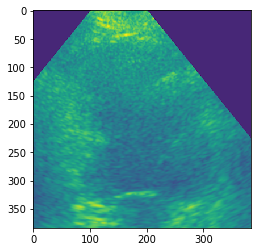

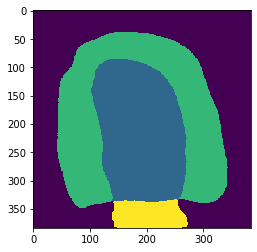

In [28]:
plt.imshow(test_frames[2,:,:,0])
plt.show()
plt.imshow(y)
plt.show()